In [1]:
%matplotlib inline
import os
import pandas as pd
import librosa
import glob 
import librosa.display
import argparse
import sys
from functools import reduce
from IPython.display import display, Audio
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from scipy.io.wavfile import read as wavread

In [2]:
#adapt 2d convolution to 1d
LEN = 16384
def conv1d_transpose(inputs, filters, kernel_width, stride = 4, padding = 'same', upsample = 'zeros'):
    return tf.layers.conv2d_transpose(
        tf.expand_dims(inputs, axis=1),
        filters,
        (1, kernel_width),
        strides=(1, stride),
        padding='same'
        )[:, 0]

In [3]:
#Generator
def WaveGANGenerator(
    z,
    slice_len=16384,
    nch=1,
    kernel_len=25,
    dim=64,
    use_batchnorm=False,
    upsample='zeros',
    train=False):
    batch_size = tf.shape(z)[0]

    # FC and reshape for convolution
    # [100] -> [16, 1024]
    dim_mul = 16
    output = z
    with tf.variable_scope('z_project'):
        output = tf.layers.dense(output, 4 * 4 * dim * dim_mul)
        output = tf.reshape(output, [batch_size, 16, dim * dim_mul])
    output = tf.nn.relu(output)
    dim_mul //= 2

    # Layer 0
    # [16, 1024] -> [64, 512]
    with tf.variable_scope('upconv_0'):
        output = conv1d_transpose(output, dim * dim_mul, kernel_len, 4, upsample=upsample)
    output = tf.nn.relu(output)
    dim_mul //= 2

    # Layer 1
    # [64, 512] -> [256, 256]
    with tf.variable_scope('upconv_1'):
        output = conv1d_transpose(output, dim * dim_mul, kernel_len, 4, upsample=upsample)
    output = tf.nn.relu(output)
    dim_mul //= 2

    # Layer 2
    # [256, 256] -> [1024, 128]
    with tf.variable_scope('upconv_2'):
        output = conv1d_transpose(output, dim * dim_mul, kernel_len, 4, upsample=upsample)
    output = tf.nn.relu(output)
    dim_mul //= 2

    # Layer 3
    # [1024, 128] -> [4096, 64]
    with tf.variable_scope('upconv_3'):
        output = conv1d_transpose(output, dim * dim_mul, kernel_len, 4, upsample=upsample)
    output = tf.nn.relu(output)

    # Layer 4
    # [4096, 64] -> [16384, nch]
    with tf.variable_scope('upconv_4'):
        output = conv1d_transpose(output, nch, kernel_len, 4, upsample=upsample)
    output = tf.nn.tanh(output)

    return output


In [4]:
#RELU function
def lrelu(inputs, alpha=0.2):
    return tf.maximum(alpha * inputs, inputs)

In [5]:
def apply_phaseshuffle(x, rad, pad_type='reflect'):
    b, x_len, nch = x.get_shape().as_list()

    phase = tf.random_uniform([], minval=-rad, maxval=rad + 1, dtype=tf.int32)
    pad_l = tf.maximum(phase, 0)
    pad_r = tf.maximum(-phase, 0)
    phase_start = pad_r
    x = tf.pad(x, [[0, 0], [pad_l, pad_r], [0, 0]], mode=pad_type)

    x = x[:, phase_start:phase_start+x_len]
    x.set_shape([b, x_len, nch])

    return x

In [6]:
#Discriminator
def WaveGANDiscriminator(
    x,
    kernel_len=25,
    dim=64,
    use_batchnorm=False,
    phaseshuffle_rad=0):
    batch_size = tf.shape(x)[0]
    slice_len = int(x.get_shape()[1])
    
    if use_batchnorm:
        batchnorm = lambda x: tf.layers.batch_normalization(x, training=True)
    else:
        batchnorm = lambda x: x

    if phaseshuffle_rad > 0:
        phaseshuffle = lambda x: apply_phaseshuffle(x, phaseshuffle_rad)
    else:
        phaseshuffle = lambda x: x

  # Layer 0
  # [16384, 1] -> [4096, 64]
    output = x
    with tf.variable_scope('downconv_0'):
        output = tf.layers.conv1d(output, dim, kernel_len, 4, padding='SAME')
    output = lrelu(output)
    output = phaseshuffle(output)
    
  # Layer 1
  # [4096, 64] -> [1024, 128]
    with tf.variable_scope('downconv_1'):
        output = tf.layers.conv1d(output, dim * 2, kernel_len, 4, padding='SAME')
    output = lrelu(output)
    output = phaseshuffle(output)

  # Layer 2
  # [1024, 128] -> [256, 256]
    with tf.variable_scope('downconv_2'):
        output = tf.layers.conv1d(output, dim * 4, kernel_len, 4, padding='SAME')
    output = lrelu(output)
    output = phaseshuffle(output)

  # Layer 3
  # [256, 256] -> [64, 512]
    with tf.variable_scope('downconv_3'):
        output = tf.layers.conv1d(output, dim * 8, kernel_len, 4, padding='SAME')
    output = lrelu(output)
    output = phaseshuffle(output)

  # Layer 4
  # [64, 512] -> [16, 1024]
    with tf.variable_scope('downconv_4'):
        output = tf.layers.conv1d(output, dim * 16, kernel_len, 4, padding='SAME')
    output = lrelu(output)
    output = phaseshuffle(output)

  # Flatten
    output = tf.reshape(output, [batch_size, -1])

  # Connect to single logit
    with tf.variable_scope('output'):
        output = tf.layers.dense(output, 1)[:, 0]

    return output

In [7]:
import loader

In [8]:
def train(fps, args):
    with tf.name_scope('loader'):
        x = loader.decode_extract_and_batch(
            fps,
            batch_size=args.train_batch_size,
            slice_len=args.data_slice_len,
            decode_fs=args.data_sample_rate,
            decode_num_channels=args.data_num_channels,
            decode_fast_wav=args.data_fast_wav,
            decode_parallel_calls=4,
            slice_randomize_offset=False if args.data_first_slice else True,
            slice_first_only=args.data_first_slice,
            slice_overlap_ratio=0. if args.data_first_slice else args.data_overlap_ratio,
            slice_pad_end=True if args.data_first_slice else args.data_pad_end,
            repeat=True,
            shuffle=True,
            shuffle_buffer_size=4096,
            prefetch_size=args.train_batch_size * 4,
            prefetch_gpu_num=args.data_prefetch_gpu_num)[:, :, 0]

    # Make z vector
    z = tf.random_uniform([args.train_batch_size, args.wavegan_latent_dim], -1., 1., dtype=tf.float32)

    # Make generator
    with tf.variable_scope('G'):
        G_z = WaveGANGenerator(z, train=True, **args.wavegan_g_kwargs)
        if args.wavegan_genr_pp:
            with tf.variable_scope('pp_filt'):
                G_z = tf.layers.conv1d(G_z, 1, args.wavegan_genr_pp_len, use_bias=False, padding='same')
    G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='G')

    # Print G summary
    print('-' * 80)
    print('Generator vars')
    nparams = 0
    for v in G_vars:
        v_shape = v.get_shape().as_list()
        v_n = reduce(lambda x, y: x * y, v_shape)
        nparams += v_n
        print('{} ({}): {}'.format(v.get_shape().as_list(), v_n, v.name))
    print('Total params: {} ({:.2f} MB)'.format(nparams, (float(nparams) * 4) / (1024 * 1024)))

    # Summarize
    tf.summary.audio('x', x, args.data_sample_rate)
    tf.summary.audio('G_z', G_z, args.data_sample_rate)
    G_z_rms = tf.sqrt(tf.reduce_mean(tf.square(G_z[:, :, 0]), axis=1))
    x_rms = tf.sqrt(tf.reduce_mean(tf.square(x[:, :, 0]), axis=1))
    tf.summary.histogram('x_rms_batch', x_rms)
    tf.summary.histogram('G_z_rms_batch', G_z_rms)
    tf.summary.scalar('x_rms', tf.reduce_mean(x_rms))
    tf.summary.scalar('G_z_rms', tf.reduce_mean(G_z_rms))

    # Make real discriminator
    with tf.name_scope('D_x'), tf.variable_scope('D'):
        D_x = WaveGANDiscriminator(x, **args.wavegan_d_kwargs)
    D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='D')

    # Print D summary
    print('-' * 80)
    print('Discriminator vars')
    nparams = 0
    for v in D_vars:
        v_shape = v.get_shape().as_list()
        v_n = reduce(lambda x, y: x * y, v_shape)
        nparams += v_n
        print('{} ({}): {}'.format(v.get_shape().as_list(), v_n, v.name))
    print('Total params: {} ({:.2f} MB)'.format(nparams, (float(nparams) * 4) / (1024 * 1024)))
    print('-' * 80)

    # Make fake discriminator
    with tf.name_scope('D_G_z'), tf.variable_scope('D', reuse=True):
        D_G_z = WaveGANDiscriminator(G_z, **args.wavegan_d_kwargs)

    # Create loss
    D_clip_weights = None
    if args.wavegan_loss == 'dcgan':
        fake = tf.zeros([args.train_batch_size], dtype=tf.float32)
        real = tf.ones([args.train_batch_size], dtype=tf.float32)

        G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
          logits=D_G_z,
          labels=real
        ))

        D_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
          logits=D_G_z,
          labels=fake
        ))
        D_loss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
          logits=D_x,
          labels=real
        ))

        D_loss /= 2.
    elif args.wavegan_loss == 'lsgan':
        G_loss = tf.reduce_mean((D_G_z - 1.) ** 2)
        D_loss = tf.reduce_mean((D_x - 1.) ** 2)
        D_loss += tf.reduce_mean(D_G_z ** 2)
        D_loss /= 2.
    elif args.wavegan_loss == 'wgan':
        G_loss = -tf.reduce_mean(D_G_z)
        D_loss = tf.reduce_mean(D_G_z) - tf.reduce_mean(D_x)

        with tf.name_scope('D_clip_weights'):
            clip_ops = []
            for var in D_vars:
                clip_bounds = [-.01, .01]
                clip_ops.append(
                  tf.assign(
                    var,
                    tf.clip_by_value(var, clip_bounds[0], clip_bounds[1])
                  )
                )
            D_clip_weights = tf.group(*clip_ops)
    elif args.wavegan_loss == 'wgan-gp':
        G_loss = -tf.reduce_mean(D_G_z)
        D_loss = tf.reduce_mean(D_G_z) - tf.reduce_mean(D_x)

        alpha = tf.random_uniform(shape=[args.train_batch_size, 1, 1], minval=0., maxval=1.)
        differences = G_z - x
        interpolates = x + (alpha * differences)
        with tf.name_scope('D_interp'), tf.variable_scope('D', reuse=True):
            D_interp = WaveGANDiscriminator(interpolates, **args.wavegan_d_kwargs)

        LAMBDA = 10
        gradients = tf.gradients(D_interp, [interpolates])[0]
        slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1, 2]))
        gradient_penalty = tf.reduce_mean((slopes - 1.) ** 2.)
        D_loss += LAMBDA * gradient_penalty
    else:
        raise NotImplementedError()

    tf.summary.scalar('G_loss', G_loss)
    tf.summary.scalar('D_loss', D_loss)

    # Create (recommended) optimizer
    if args.wavegan_loss == 'dcgan':
        G_opt = tf.train.AdamOptimizer(
            learning_rate=2e-4,
            beta1=0.5)
        D_opt = tf.train.AdamOptimizer(
            learning_rate=2e-4,
            beta1=0.5)
    elif args.wavegan_loss == 'lsgan':
        G_opt = tf.train.RMSPropOptimizer(
            learning_rate=1e-4)
        D_opt = tf.train.RMSPropOptimizer(
            learning_rate=1e-4)
    elif args.wavegan_loss == 'wgan':
        G_opt = tf.train.RMSPropOptimizer(
            learning_rate=5e-5)
        D_opt = tf.train.RMSPropOptimizer(
            learning_rate=5e-5)
    elif args.wavegan_loss == 'wgan-gp':
        G_opt = tf.train.AdamOptimizer(
            learning_rate=1e-4,
            beta1=0.5,
            beta2=0.9)
        D_opt = tf.train.AdamOptimizer(
            learning_rate=1e-4,
            beta1=0.5,
            beta2=0.9)
    else:
        raise NotImplementedError()

    # Create training ops
    G_train_op = G_opt.minimize(G_loss, var_list=G_vars,
        global_step=tf.train.get_or_create_global_step())
    D_train_op = D_opt.minimize(D_loss, var_list=D_vars)

    # Run training
    with tf.train.MonitoredTrainingSession(
      checkpoint_dir=args.train_dir,
      save_checkpoint_secs=args.train_save_secs,
      save_summaries_secs=args.train_summary_secs) as sess:
        while True:
          # Train discriminator
          for i in range(args.wavegan_disc_nupdates):
            sess.run(D_train_op)

            # Enforce Lipschitz constraint for WGAN
            if D_clip_weights is not None:
                sess.run(D_clip_weights)

          # Train generator
          sess.run(G_train_op)

In [9]:
def infer(args):
    infer_dir = os.path.join(args.train_dir, 'infer')
    if not os.path.isdir(infer_dir):
        os.makedirs(infer_dir)

    # Subgraph that generates latent vectors
    samp_z_n = tf.placeholder(tf.int32, [], name='samp_z_n')
    samp_z = tf.random_uniform([samp_z_n, args.wavegan_latent_dim], -1.0, 1.0, dtype=tf.float32, name='samp_z')

    # Input zo
    z = tf.placeholder(tf.float32, [None, args.wavegan_latent_dim], name='z')
    flat_pad = tf.placeholder(tf.int32, [], name='flat_pad')

    # Execute generator
    with tf.variable_scope('G'):
        G_z = WaveGANGenerator(z, train=False, **args.wavegan_g_kwargs)
        if args.wavegan_genr_pp:
            with tf.variable_scope('pp_filt'):
                G_z = tf.layers.conv1d(G_z, 1, args.wavegan_genr_pp_len, use_bias=False, padding='same')
    G_z = tf.identity(G_z, name='G_z')

    # Flatten batch
    nch = int(G_z.get_shape()[-1])
    G_z_padded = tf.pad(G_z, [[0, 0], [0, flat_pad], [0, 0]])
    G_z_flat = tf.reshape(G_z_padded, [-1, nch], name='G_z_flat')

    # Encode to int16
    def float_to_int16(x, name=None):
        x_int16 = x * 32767.
        x_int16 = tf.clip_by_value(x_int16, -32767., 32767.)
        x_int16 = tf.cast(x_int16, tf.int16, name=name)
        return x_int16
    G_z_int16 = float_to_int16(G_z, name='G_z_int16')
    G_z_flat_int16 = float_to_int16(G_z_flat, name='G_z_flat_int16')

    # Create saver
    G_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='G')
    global_step = tf.train.get_or_create_global_step()
    saver = tf.train.Saver(G_vars + [global_step])

    # Export graph
    tf.train.write_graph(tf.get_default_graph(), infer_dir, 'infer.pbtxt')

    # Export MetaGraph
    infer_metagraph_fp = os.path.join(infer_dir, 'infer.meta')
    tf.train.export_meta_graph(
      filename=infer_metagraph_fp,
      clear_devices=True,
      saver_def=saver.as_saver_def())

    # Reset graph (in case training afterwards)
    tf.reset_default_graph()

## Training

In [ ]:
tf.reset_default_graph()
os.chdir('C:\\Users\\hosle\\Documents\\_capstone\\_MyWavGan')
class parser:
    data_sample_rate = 22050
    data_slice_len = 16384
    data_num_channels = 1
    data_overlap_ratio = 0.0
    data_first_slice = True
    data_pad_end = False
    data_normalize = False
    data_fast_wav = True
    data_prefetch_gpu_num = 0
    wavegan_latent_dim = 100
    wavegan_kernel_len = 25
    wavegan_dim = 64
    wavegan_batchnorm = False
    wavegan_disc_nupdates = 5
    wavegan_loss = 'wgan-gp'
    wavegan_genr_upsample = 'zeros'
    wavegan_genr_pp = False
    wavegan_genr_pp_len = 512
    wavegan_disc_phaseshuffle = 2
    train_batch_size = 64
    train_save_secs = 300
    train_summary_secs = 120
    preview_n = 32
    incept_metagraph_fp = './eval/inception/infer.meta'
    incept_ckpt_fp = './eval/inception/best_acc-103005'
    incept_n = 5000
    incept_k = 10
    data_dir = 'C:\\Users\\hosle\\Documents\\_capstone\\GUNWAV'
    mode = 'train'
    train_dir = './train'

args = parser

# Make train dir
if not os.path.isdir(args.train_dir):
    os.makedirs(args.train_dir)

# Save args
with open(os.path.join(args.train_dir, 'args.txt'), 'w') as f:
    f.write('\n'.join([str(k) + ',' + str(v) for k, v in sorted(vars(args).items(), key=lambda x: x[0])]))

# Make model kwarg dicts
setattr(args, 'wavegan_g_kwargs', {
    'slice_len': args.data_slice_len,
    'nch': args.data_num_channels,
    'kernel_len': args.wavegan_kernel_len,
    'dim': args.wavegan_dim,
    'use_batchnorm': args.wavegan_batchnorm,
    'upsample': args.wavegan_genr_upsample
})
setattr(args, 'wavegan_d_kwargs', {
    'kernel_len': args.wavegan_kernel_len,
    'dim': args.wavegan_dim,
    'use_batchnorm': args.wavegan_batchnorm,
    'phaseshuffle_rad': args.wavegan_disc_phaseshuffle
})

if args.mode == 'train':
    fps = glob.glob(os.path.join(args.data_dir, '*'))
    print('Found {} audio files in specified directory'.format(len(fps)))
    infer(args)
    train(fps, args)


In [10]:
def plot_time_series(data):
    fig = plt.figure(figsize=(9, 5))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()

In [11]:
os.chdir('C:\\Users\\hosle\\Documents\\_capstone\\_MyWavGan\\train')

# Load the graph
tf.reset_default_graph()
saver = tf.train.import_meta_graph('infer\\infer.meta')
graph = tf.get_default_graph()
sess = tf.InteractiveSession()
saver.restore(sess, 'model.ckpt-8837')

# Create 50 random latent vectors z
_z = (np.random.rand(50, 100) * 2) - 1

# Synthesize G(z)
z = graph.get_tensor_by_name('z:0')
G_z = graph.get_tensor_by_name('G_z:0')
_G_z = sess.run(G_z, {z: _z})
sess.close()

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from model.ckpt-8837


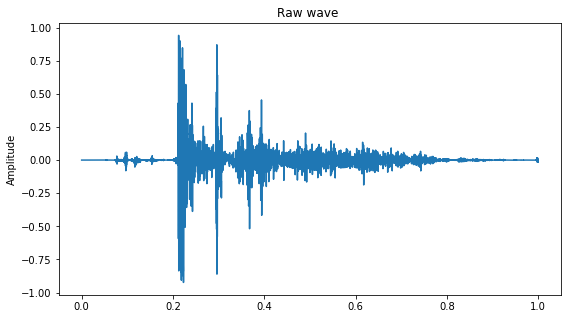

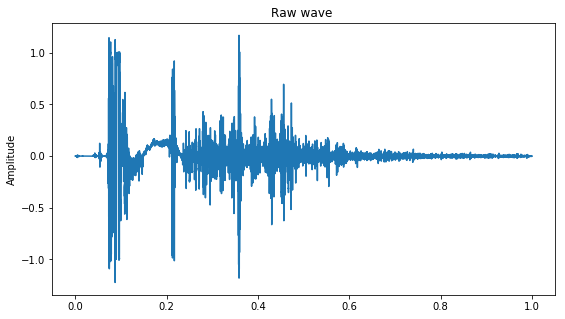

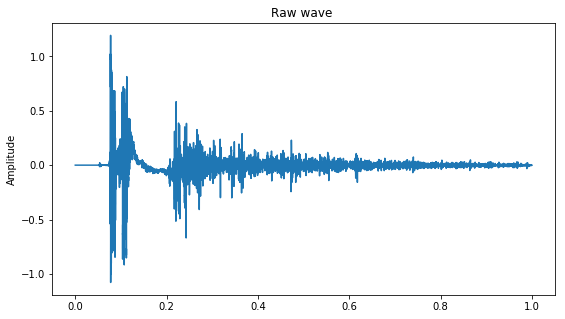

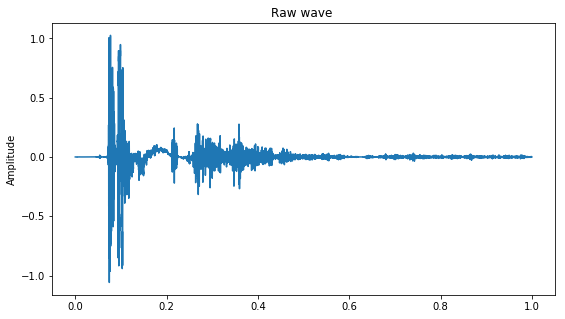

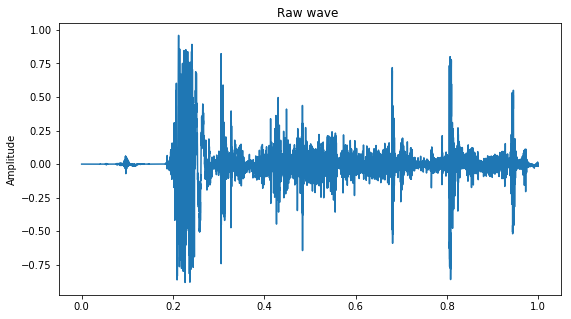

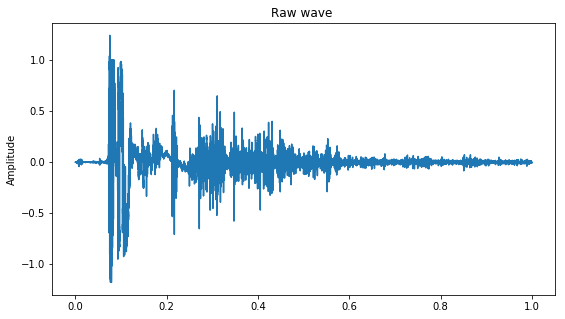

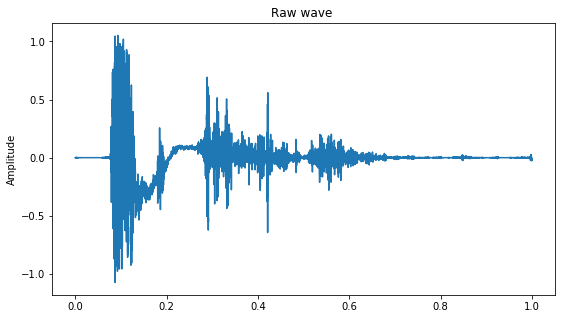

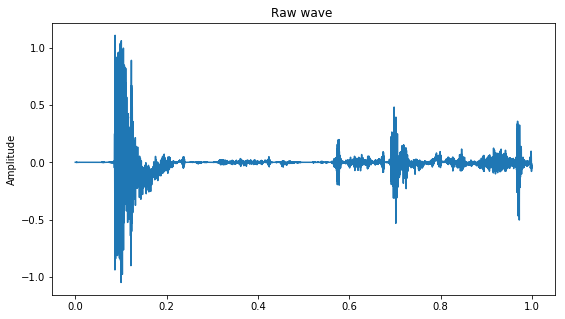

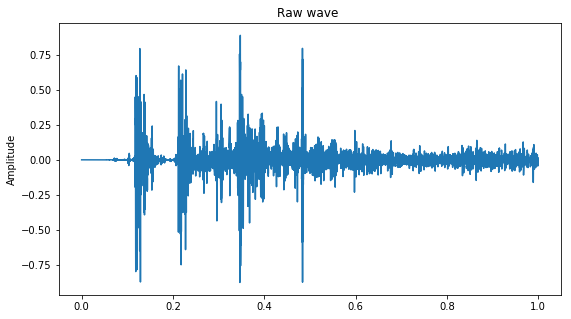

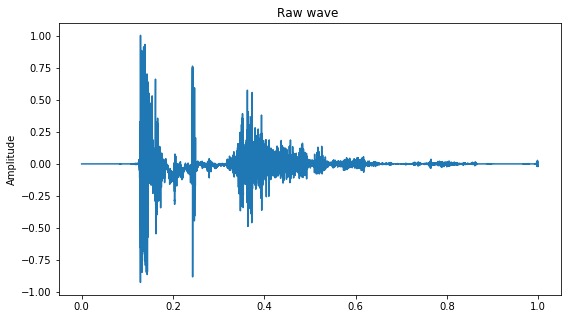

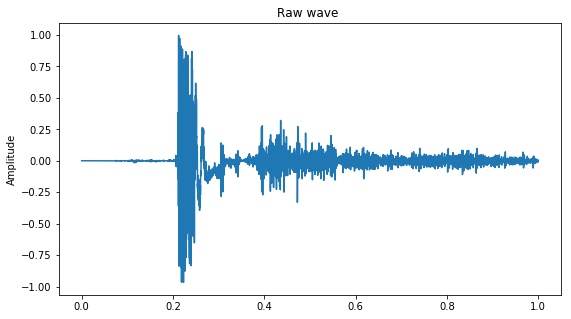

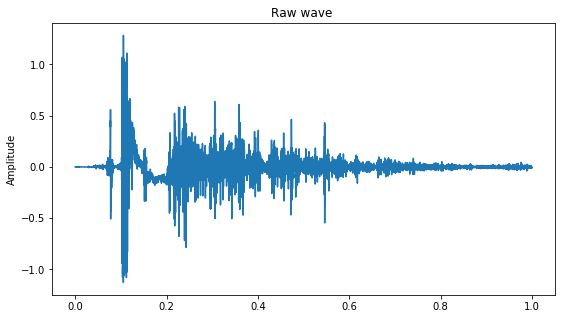

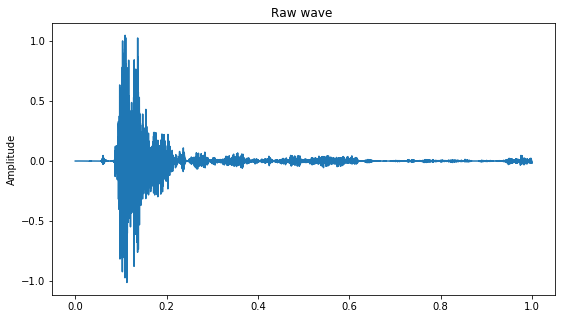

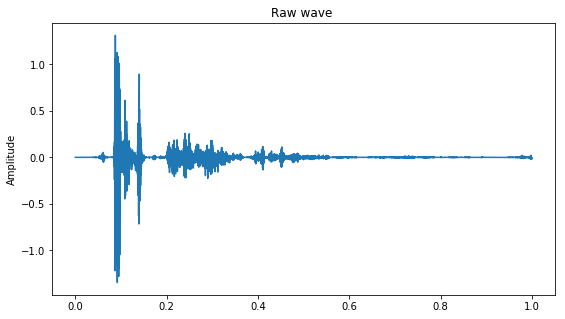

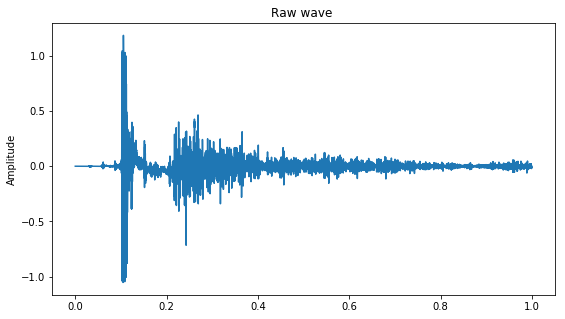

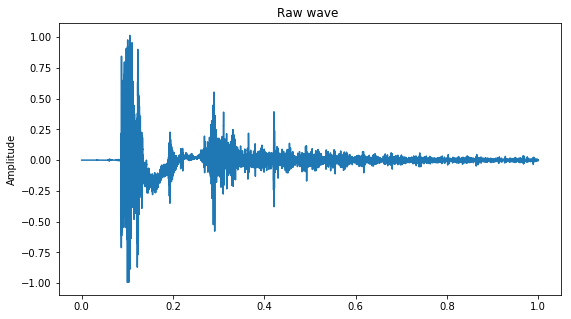

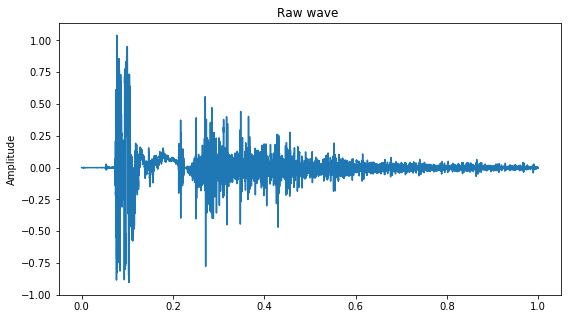

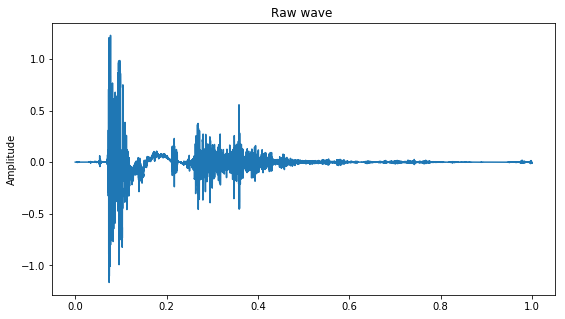

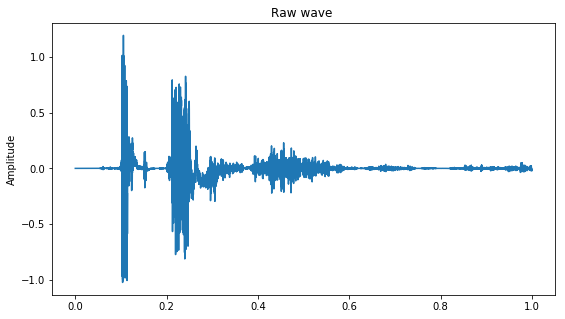

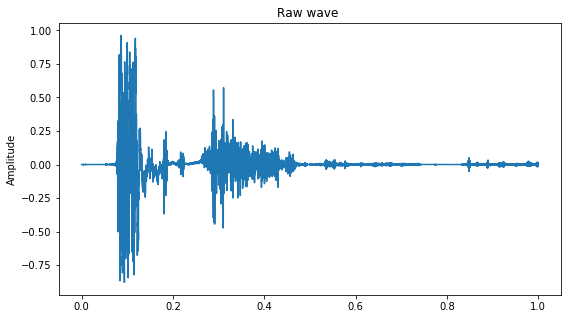

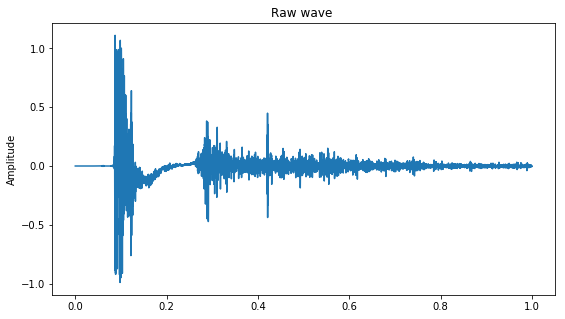

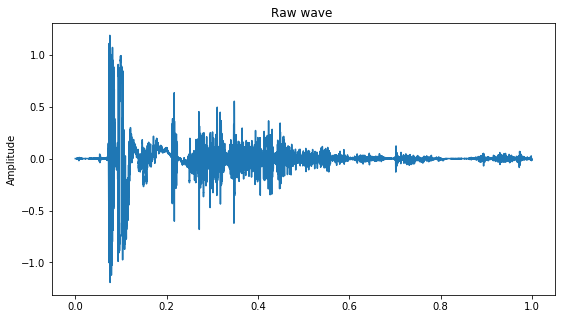

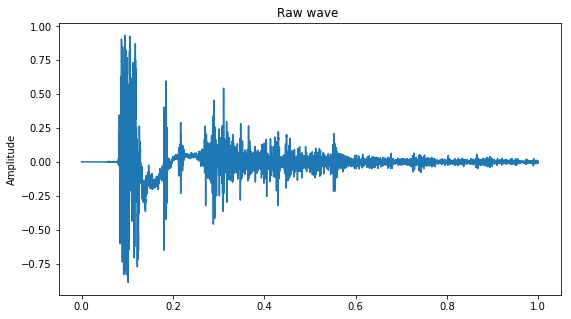

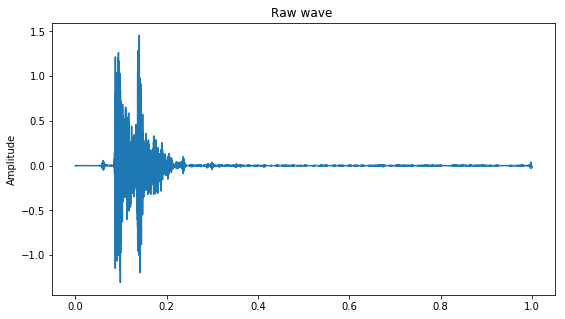

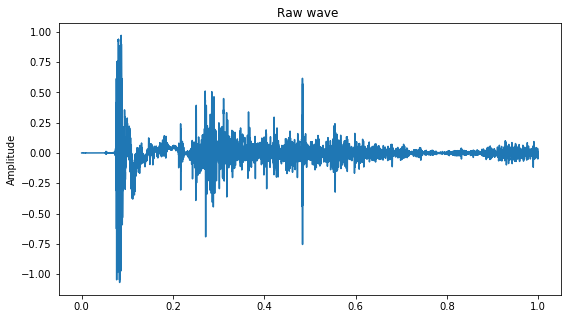

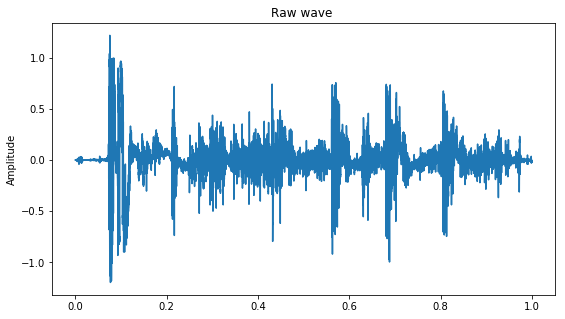

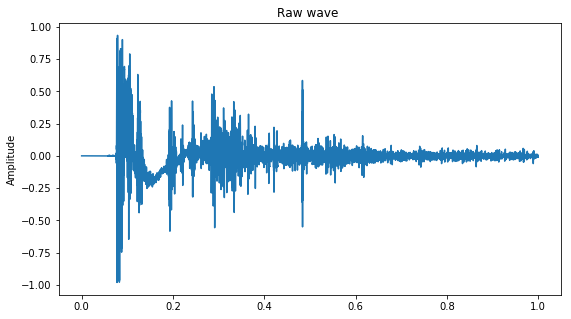

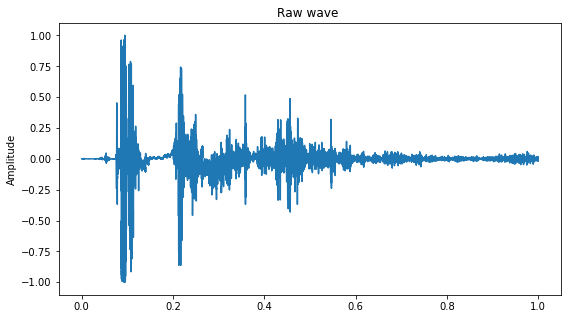

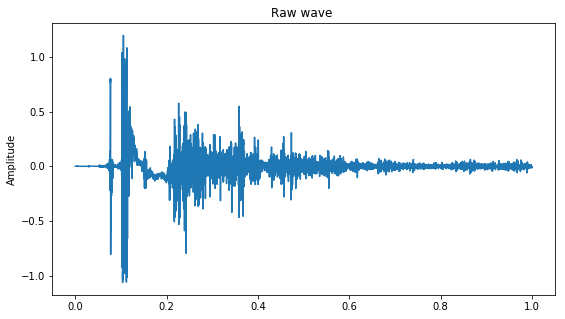

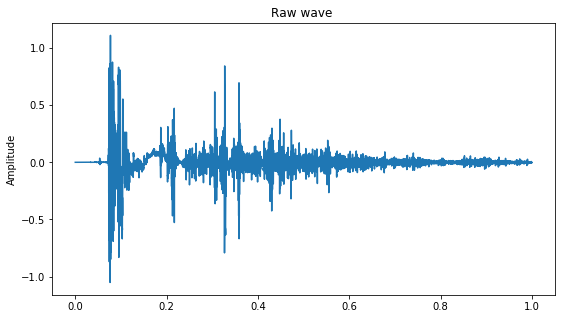

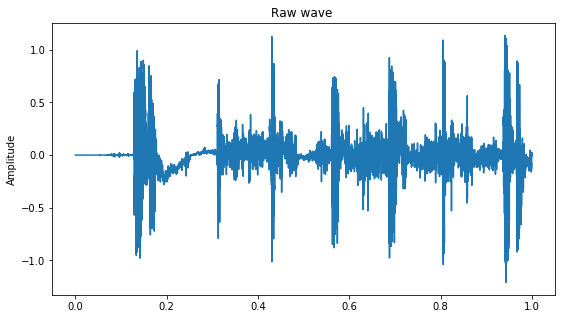

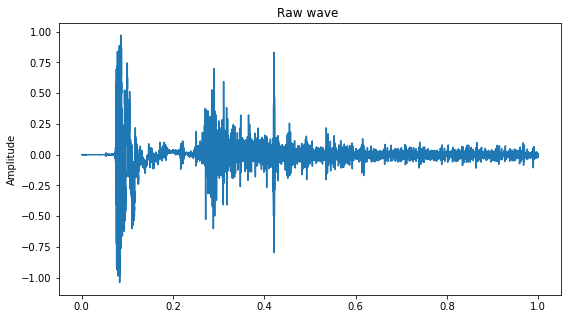

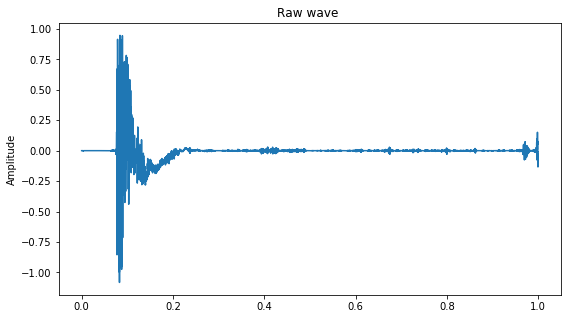

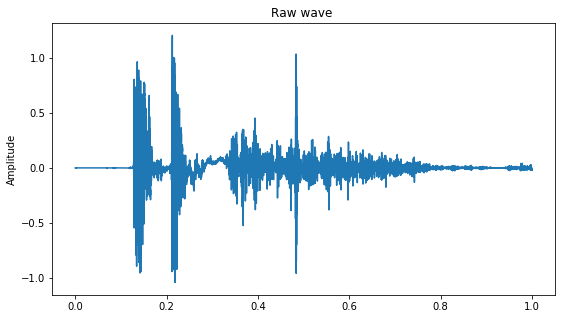

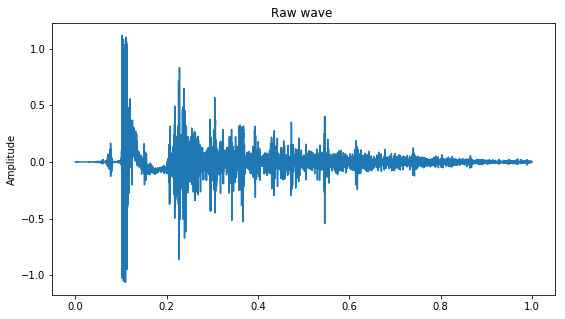

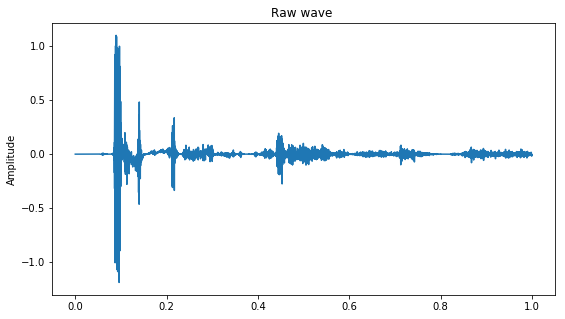

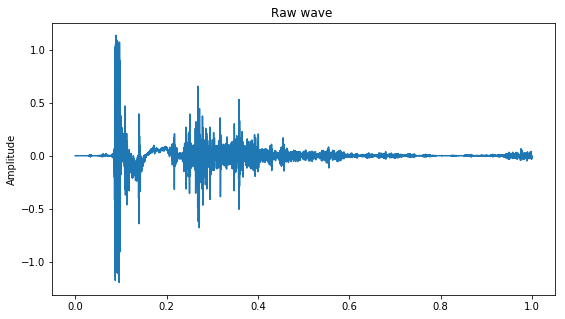

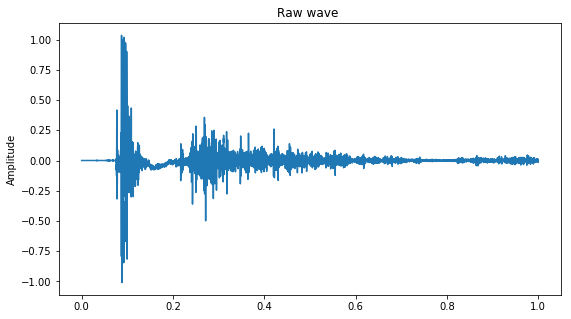

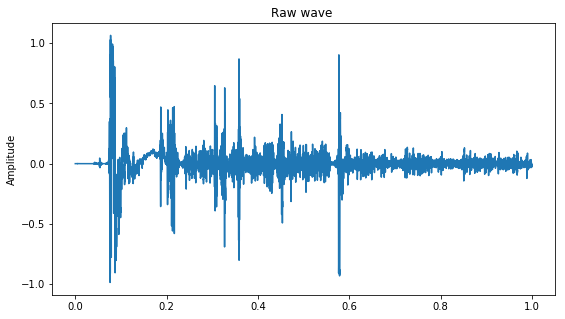

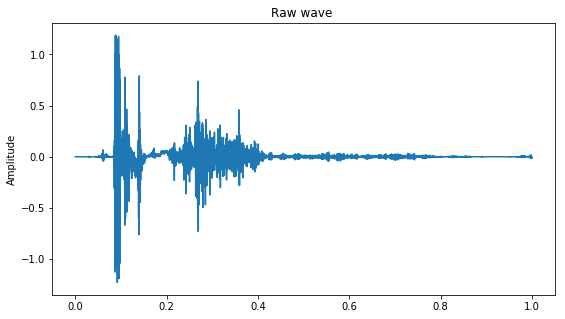

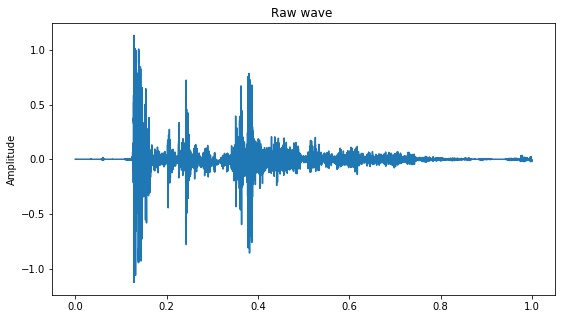

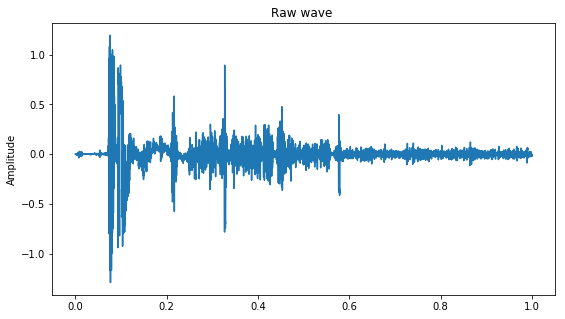

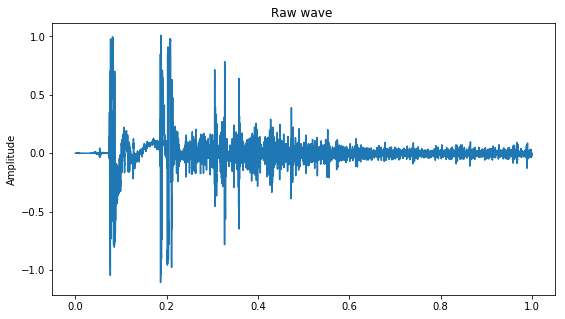

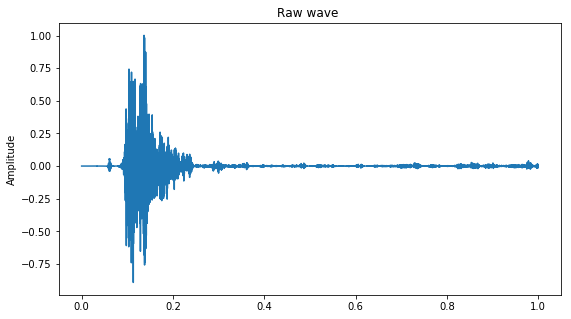

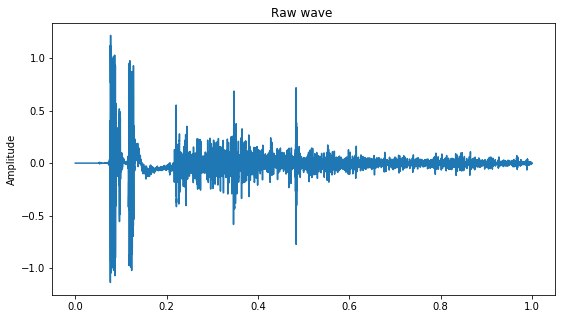

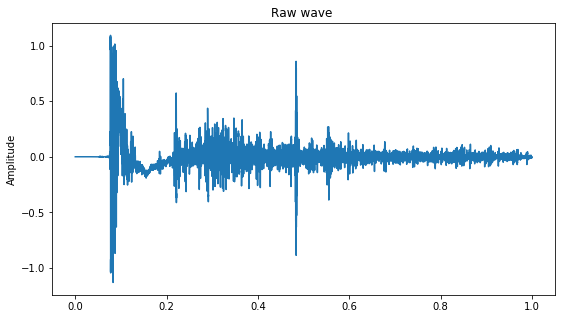

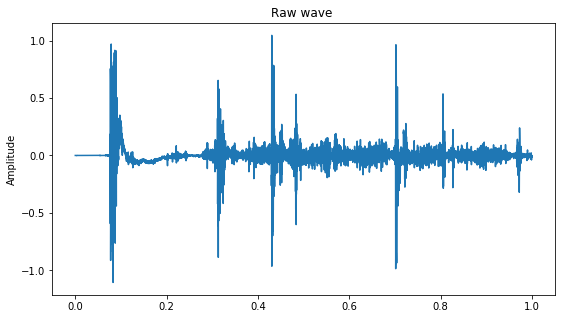

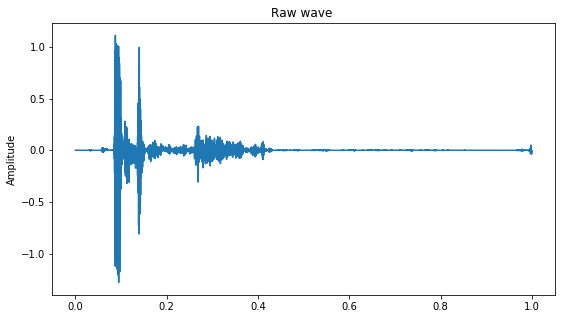

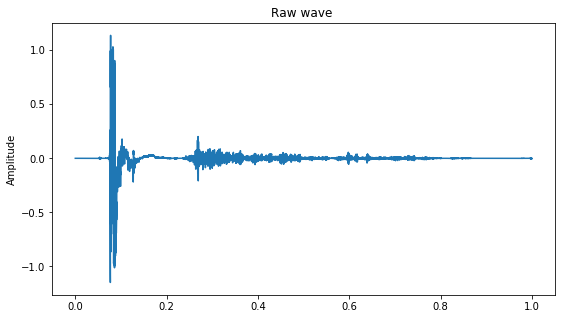

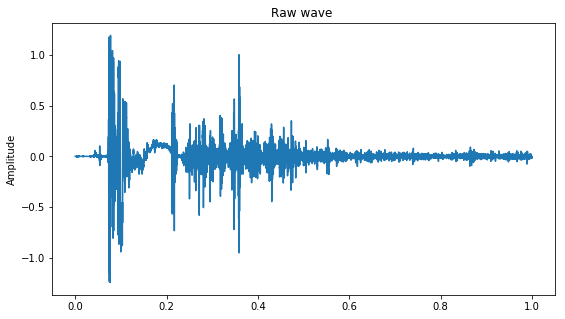

In [12]:
orig_rate = 16384
rate = 22050
for x in range (50):
    #data = _G_z[x, :, 0]
    data = librosa.resample(_G_z[x, :, 0], orig_rate, rate)
    plot_time_series(data)
    
    # Play audio in notebook
    display(Audio(data, rate = rate))

In [ ]:
real, _ = librosa.load("C:\\Users\\hosle\\Documents\\_capstone\\AK47\\Rifle,Fully Automatic,Machine Gun,Assault Rifle,7.62x39mm,AK-47,Gunshots,Processed,Long Burst,1,Close with Tail.mp3.wav", sr=22050, duration=1)

In [ ]:
real, _ = librosa.load("C:\\Users\\hosle\\Documents\\_capstone\\OneBolt\\Rifle,Bolt Action,.30-06,Springfield 1917,Gunshot,Processed,1,Close with Tail.mp3.wav", sr=22050, duration=1)

In [24]:
real, _ = librosa.load("C:\\Users\\hosle\\Documents\\_capstone\\One\\Revolver0.wav", sr=orig_rate, duration=1)

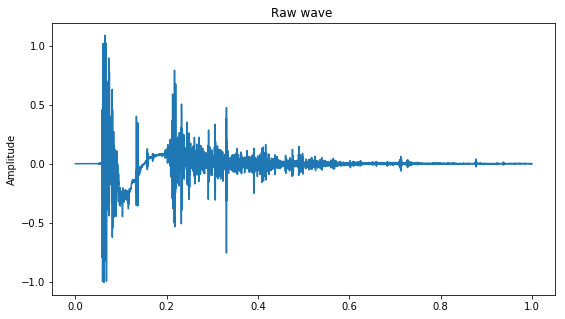

In [26]:
plot_time_series(real)
display(Audio(librosa.resample(real, orig_rate, rate), rate = 22050))

In [29]:
real, _ = librosa.load("C:\\Users\\hosle\\Documents\\_capstone\\One\\Revolver0.wav", sr=rate, duration=1)
display(Audio(real, rate = 22050))

In [ ]:
len(real), len(_G_z[0, :, 0])

In [ ]:
np.sum((real[0:16384]-_G_z[0, :, 0])**2)